## **1. Dataset**

The goal of this project is to build an NLP system that can automatically classify mobile text messages as either ham (legitimate) or spam. For this, the SMS Spam Collection dataset is used. It contains 5,572 real-world SMS messages collected from mobile platforms, each manually labelled as “ham” or “spam”. Since SMS spam is a common and persistent issue that affects user privacy and can lead to scams, building an automated detection system is both useful and necessary.

The dataset is well-suited for binary classification, and the text-based nature of the problem makes it ideal for comparing different NLP approaches. Before applying any machine learning models, the data is loaded, inspected for structure, and explored for characteristics such as class distribution and message length. Basic preprocessing is applied, including converting text to lowercase, removing punctuation, and normalising spacing. This helps prepare the messages for vectorisation and reduces noise in the representation.

Initial exploration also includes analysing common words found in both spam and ham messages to better understand the dataset. This gives insight into the patterns each class contains, such as promotional keywords in spam and conversational language in ham. Overall, the dataset provides a strong foundation for comparing classical NLP methods with modern embedding-based models.

Dataset source: UCI Machine Learning Repository - SMS Spam Collection.

In [15]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the SMS Spam dataset
df = pd.read_csv("data/SMSSpamCollection",
                 sep='\t', 
                 header=None, 
                 names=["label", "message"],
                 encoding="utf-8")

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (5572, 2)


,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


**Table 1.1**: Initial inspection of the dataset showing the first five rows.

In [16]:
# Summary
print(df.info())

# Check class distribution
print(df['label'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   label    5572 non-null   object
 1   message  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB
None
label
ham     4825
spam     747
Name: count, dtype: int64


5,572 non-null entries for both columns. A significant class imbalance: 4,825 'ham' messages versus only 747 'spam' messages.

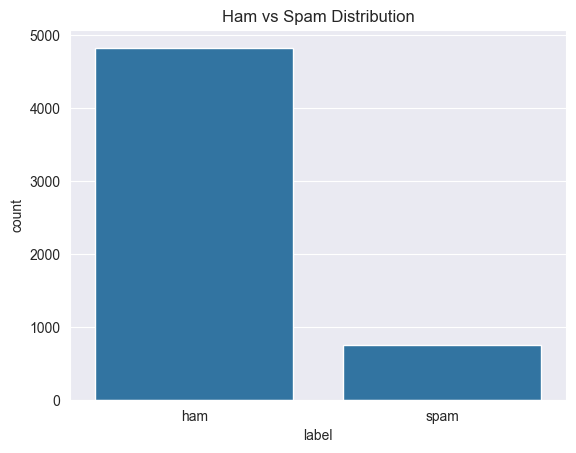

In [17]:
# Add message length (optional helpful feature for EDA)
df['message_length'] = df['message'].apply(len)

# Plot class distribution
sns.countplot(data=df, x='label')
plt.title("Ham vs Spam Distribution")
plt.show()

**Figure 1.1**: Class Distribution of SMS Messages. This bar chart shows the severe class imbalance in the dataset, with a high count of 'ham' messages compared to 'spam' messages.

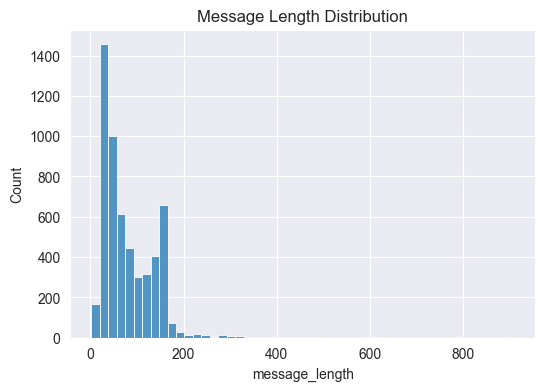

In [18]:
# Plot message length distribution
plt.figure(figsize=(6,4))
sns.histplot(df['message_length'], bins=50)
plt.title("Message Length Distribution")
plt.show()

**Figure 1.2**: Overall Distribution of Message Length. The histogram shows that the majority of messages are very short (peaking below 200 characters), with a long tail of increasingly longer messages.

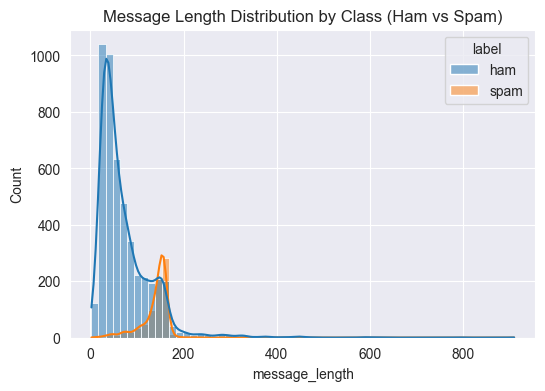

In [19]:
# Class-wise distribution of message length
plt.figure(figsize=(6,4))
sns.histplot(data=df, x='message_length', hue='label', bins=60, kde=True)
plt.title("Message Length Distribution by Class (Ham vs Spam)")
plt.show()

**Figure 1.3**: Comparative Message Length Distribution. This density plot highlights the key difference: spam messages (orange) are typically much longer than ham messages (blue), which are concentrated at shorter lengths.

In [20]:
df['message_clean'] = df['message'].str.lower()

import string

df['message_clean'] = df['message_clean'].str.replace(f"[{string.punctuation}]", "", regex=True)

df['message_clean'] = df['message_clean'].str.strip()
df['message_clean'] = df['message_clean'].str.replace('\s+', ' ', regex=True)

# Top word frequency analysis
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(stop_words='english')
X_cv = cv.fit_transform(df['message_clean'])

word_counts = pd.DataFrame(X_cv.toarray(), columns=cv.get_feature_names_out())
df_counts = pd.concat([df['label'], word_counts], axis=1)

spam_words = df_counts[df_counts['label']=="spam"].drop(columns=['label']).sum().sort_values(ascending=False).head(20)
ham_words = df_counts[df_counts['label']=="ham"].drop(columns=['label']).sum().sort_values(ascending=False).head(20)

print("Top Spam Words:\n", spam_words)
print("\nTop Ham Words:\n", ham_words)

Top Spam Words:
 free       216
txt        150
ur         144
mobile     123
text       120
stop       115
claim      113
reply      101
prize       92
just        78
won         73
new         69
send        68
nokia       65
urgent      63
cash        62
win         60
contact     56
service     55
16          51
dtype: int64

Top Ham Words:
 im       451
just     290
ltgt     276
ok       273
dont     263
ur       246
ill      238
know     232
got      232
like     231
come     227
good     224
love     190
day      190
time     189
going    167
want     164
lor      160
home     160
need     157
dtype: int64


Top 20 most frequent words (excluding stop words) in the dataset. Spam words include promotional and urgent terms (e.g., 'free', 'win', 'urgent', 'prize'), while Ham words are characteristic of casual conversation (e.g., 'im', 'just', 'ok', 'dont').

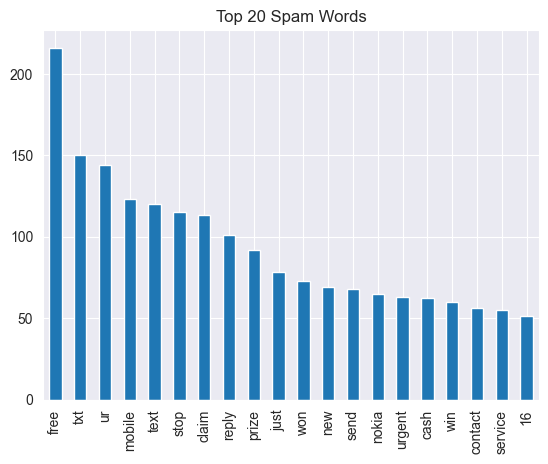

In [21]:
spam_words.plot(kind='bar', title='Top 20 Spam Words')
plt.show()

**Figure 1.4**: Top 20 Ham Words. Chart confirming casual, conversational language like 'im', 'just', and 'ok' dominates legitimate messages.

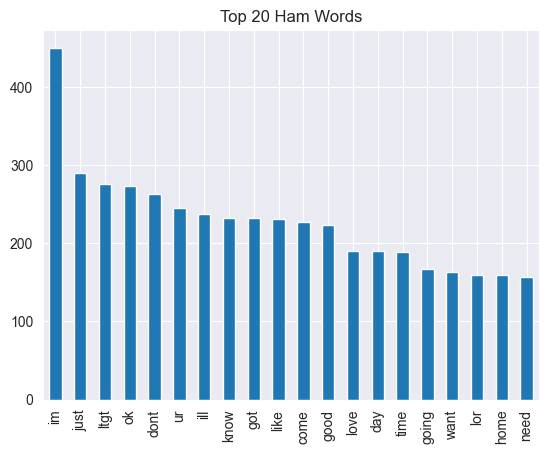

In [22]:
ham_words.plot(kind='bar', title='Top 20 Ham Words')
plt.show()

**Figure 1.5**: Top 20 Spam Words. Plot showing words related to marketing and urgency like 'free', 'win', and 'claim' are key spam indicators.

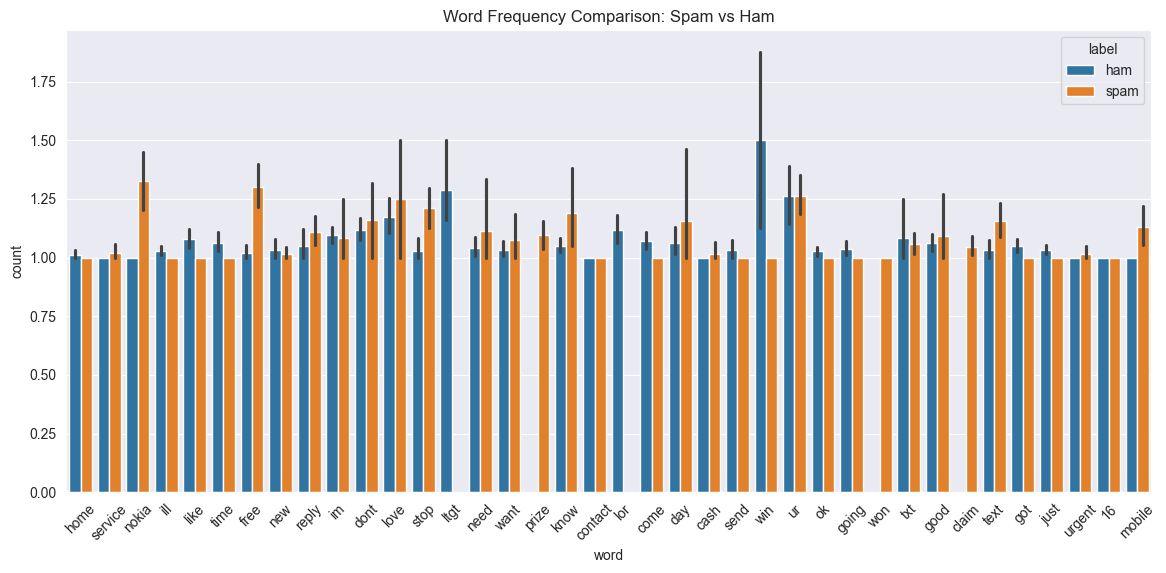

In [23]:
top_words = list(spam_words.index[:20]) + list(ham_words.index[:20])
top_words = list(set(top_words))  # remove duplicates

# Keep only label + these top words
freq_df = df_counts[['label'] + top_words]

# Melt into long format for seaborn
freq_long = freq_df.melt(
    id_vars='label',
    var_name='word',
    value_name='count'
)

# Keep only non-zero occurrences
freq_long = freq_long[freq_long['count'] > 0]

# Plot: Side-by-side bar chart for word frequencies
plt.figure(figsize=(14,6))
sns.barplot(data=freq_long, x='word', y='count', hue='label')
plt.title("Word Frequency Comparison: Spam vs Ham")
plt.xticks(rotation=45)
plt.show()

**Figure 1.6**: Word Frequency Comparison. Comparison showing words like 'won' and 'prize' are key discriminators for spam, while common short words are more frequent in ham.

In [24]:
from sklearn.model_selection import train_test_split

# Split dataset (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    df['message_clean'], 
    df['label'], 
    test_size=0.2, 
    random_state=42,
    stratify=df['label']  # preserve ham/spam ratio
)

## **2. Representation Learning**

To train machine learning models on text, it is necessary to convert the SMS messages into numerical vectors. In this project, a single representation-learning approach is used so that both classifiers operate on the same feature space, ensuring a fair comparison.

The chosen method is TF-IDF (Term Frequency–Inverse Document Frequency). TF-IDF is a traditional bag-of-words technique that represents each message based on how frequently words appear in it, adjusted by how rare those words are across the dataset. This helps highlight important terms while reducing the influence of common, low-information words. TF-IDF works especially well for short texts such as SMS messages, where specific keywords often carry strong predictive value. The resulting vectors are sparse and high-dimensional, making them well suited for classical machine learning algorithms like Naive Bayes and Logistic Regression.

By using TF-IDF for both models, the experiment focuses purely on how each classifier interprets the same textual representation, allowing a clear comparison of their strengths and limitations in the SMS spam classification task.

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("Shape of TF-IDF matrix:", X_train_tfidf.shape)

Shape of TF-IDF matrix: (4457, 8099)


In [26]:
from sklearn.naive_bayes import MultinomialNB

from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for NB
params = {'alpha': [0.1, 0.5, 1.0]}
grid = GridSearchCV(MultinomialNB(), params, cv=5)
grid.fit(X_train_tfidf, y_train)

print("Best Parameters:", grid.best_params_)

nb_best = grid.best_estimator_

Best Parameters: {'alpha': 0.5}


## **3. Algorithms**

In this project, two machine learning models are implemented, both using the same TF-IDF representation. This allows a fair comparison between two different classification algorithms while keeping the feature space constant. Although both models are widely used for text classification, they operate under different assumptions and learning principles.

**1. Multinomial Naive Bayes (NB)**
For the TF-IDF pipeline, the Multinomial Naive Bayes classifier is used. NB is a probability based algorithm that assumes features contribute independently to the final prediction. Despite this simplifying assumption, it performs strongly on the SMS dataset because specific word frequency patterns such as promotional terms or urgent phrases-tend to differentiate spam from ham. The model computes the likelihood of each word occurring in the spam and ham classes and predicts the class with the highest posterior probability. Naive Bayes is computationally efficient and particularly effective for the high-dimensional sparse vectors produced by TF-IDF. To improve its performance on unseen messages, GridSearchCV is used to tune the smoothing parameter alpha, helping the model generalise better across varied SMS phrasing.

**2. Logistic Regression (LR)**
The second model also uses TF-IDF features but applies Logistic Regression as the classifier. LR is a linear model that learns weighted decision boundaries to separate classes. Unlike Naive Bayes, it does not rely on independence assumptions and instead learns optimal weights directly from the data. While Logistic Regression typically performs exceptionally well with dense semantic embeddings, it can still serve as an effective baseline classifier on TF-IDF vectors. A higher iteration limit is used to ensure convergence due to the large number of sparse features generated by the TF-IDF transformation.

The two algorithms differ not only in their statistical assumptions but also in how they interpret TF-IDF features. Naive Bayes leverages term frequencies probabilistically, whereas Logistic Regression attempts to find an optimal linear boundary in the feature space. By evaluating both models on the same TF-IDF representation, the experiment provides a clear and controlled comparison of classical NLP classification techniques on the SMS spam detection task.

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

# Predictions
y_pred = nb_best.predict(X_test_tfidf)

# Evaluation metrics
print("Classification Report:\n", classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

         ham       0.97      1.00      0.98       966
        spam       1.00      0.78      0.88       149

    accuracy                           0.97      1115
   macro avg       0.98      0.89      0.93      1115
weighted avg       0.97      0.97      0.97      1115



Classification Report for TF-IDF + NB. The model achieved 97% overall accuracy. Key metrics show perfect precision (1.00) for the 'spam' class but a lower recall (0.78), indicating that some spam messages were missed.

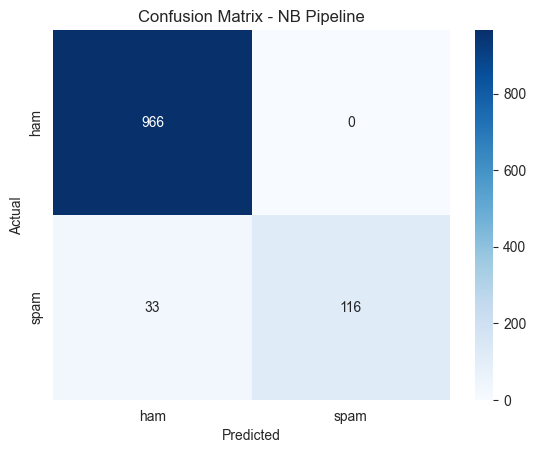

In [28]:
# Confusion matrix visualization
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['ham', 'spam'], yticklabels=['ham', 'spam'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - NB Pipeline")
plt.show()

**Figure 1.7**: Confusion Matrix for TF-IDF + NB. The matrix shows 966 True Positives (ham) and 116 True Positives (spam). Critically, the model generated 33 False Negatives (spam classified as ham) and 0 False Positives (ham classified as spam).